In [1]:
# --- NOTEBOOK 03: PREDICTIVE MODELING (LightGBM) ---

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# Konfigurasi Tampilan
pd.set_option('display.max_columns', 100)
plt.style.use('seaborn-v0_8')

# 1. LOAD DATA SIAP PAKAI
# Membaca data hasil Feature Engineering/Mining kemarin
file_path = '../data/processed/master_data_modeled.csv'
df = pd.read_csv(file_path, parse_dates=['date'])

print(f"✅ Data Berhasil Dimuat: {len(df)} baris")
print("Kolom Tersedia:")
print(df.columns.tolist())

# Cek urutan waktu (Penting untuk Time Series Split nanti)
print(f"\nRentang Data: {df['date'].min()} s.d {df['date'].max()}")

✅ Data Berhasil Dimuat: 1561206 baris
Kolom Tersedia:
['race_id', 'date', 'rank', 'horse_name', 'odds', 'popularity', 'horse_weight', 'distance', 'horse_no', 'frame_no', 'time_seconds', 'rotation_days', 'last_rank', 'last_3_avg_rank', 'race_count', 'race_seq_since_break', 'jockey_venue_win_rate', 'trainer_venue_win_rate', 'jockey_dist_cat_win_rate', 'horse_name_dist_cat_win_rate', 'horse_name_surface_win_rate', 'jockey_venue_surface_win_rate', 'venue_id', 'weather_id', 'surface_id', 'course_direction_id', 'race_class_id', 'sex_id', 'running_style_id', 'dist_cat_id']

Rentang Data: 1986-01-05 00:00:00 s.d 2021-07-31 00:00:00


In [4]:
import joblib
# --- TAHAP 1: PERSIAPAN DATA LATIH ---

# 1. Tentukan Target Prediksi
# Kita ingin memprediksi: Apakah kuda ini Juara 1? (1 = Ya, 0 = Tidak)
# Ini disebut Binary Classification.
df['target'] = (df['rank'] == 1).astype(int)

# 2. Tentukan Fitur (X) yang akan dipakai
# Buang kolom metadata yang tidak boleh dilihat model saat ujian (seperti 'rank', 'time', 'date')
drop_cols = ['race_id', 'date', 'rank', 'target', 'horse_no', 'horse_name','time_seconds'] 

features = [c for c in df.columns if c not in drop_cols]
print(f"Jumlah Fitur: {len(features)}")
print("Daftar Fitur:", features)

# --- TAHAP 2: TIME SERIES SPLITTING (PENTING!) ---

# Kita bagi data berdasarkan waktu.
# Train: Data Lama (misal sebelum 2020) -> Untuk Model Belajar
# Test: Data Baru (setelah 2020) -> Untuk Ujian Model
# Ganti tanggal 'split_date' sesuai keinginan Anda (misal 80% data lama, 20% data baru)

# Tentukan Tanggal Potong
val_start_date = '2016-01-01'  # Mulai Validasi
test_start_date = '2020-01-01' # Mulai Test (ROI)

# 1. TRAINING SET (Data Lama s.d. 2017)
# Tugas: Buat model belajar pola
train_df = df[df['date'] < val_start_date]

# 2. VALIDATION SET (2018-2019)
# Tugas: Mengatur kapan setop belajar (Early Stopping) & Tuning Hyperparameter
val_df = df[(df['date'] >= val_start_date) & (df['date'] < test_start_date)]

# 3. TEST SET (2020-Sekarang)
# Tugas: MURNI untuk Cek ROI. Model TIDAK BOLEH menyentuh ini saat training.
test_df = df[df['date'] >= test_start_date]

print(f"Data Train : {len(train_df)} baris (s.d {train_df['date'].max().date()})")
print(f"Data Val   : {len(val_df)} baris ({val_df['date'].min().date()} s.d {val_df['date'].max().date()})")
print(f"Data Test  : {len(test_df)} baris (mulai {test_df['date'].min().date()}) -> UNTUK CEK ROI")

# Siapkan X dan y
X_train = train_df[features]
y_train = train_df['target']

X_val = val_df[features]
y_val = val_df['target']

X_test = test_df[features]
y_test = test_df['target']

# --- TAHAP 3: TRAINING LIGHTGBM ---
print("\n--- Memulai Training LightGBM... ---")

# Setup Dataset untuk LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data) # Validasi pakai data Val, BUKAN Test

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'seed': 42
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data], # <--- PERHATIKAN: Kita validasi ke val_data
    valid_names=['train', 'val'],      # Label di log
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)]
)
joblib.dump(model, '../models/lgbm_model.pkl')
print("\n✅ Training Selesai!")

Jumlah Fitur: 24
Daftar Fitur: ['odds', 'popularity', 'horse_weight', 'distance', 'frame_no', 'rotation_days', 'last_rank', 'last_3_avg_rank', 'race_count', 'race_seq_since_break', 'jockey_venue_win_rate', 'trainer_venue_win_rate', 'jockey_dist_cat_win_rate', 'horse_name_dist_cat_win_rate', 'horse_name_surface_win_rate', 'jockey_venue_surface_win_rate', 'venue_id', 'weather_id', 'surface_id', 'course_direction_id', 'race_class_id', 'sex_id', 'running_style_id', 'dist_cat_id']
Data Train : 1299596 baris (s.d 2015-12-27)
Data Val   : 187974 baris (2016-01-05 s.d 2019-12-28)
Data Test  : 73636 baris (mulai 2020-01-05) -> UNTUK CEK ROI

--- Memulai Training LightGBM... ---
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.840115	val's auc: 0.841927
[100]	train's auc: 0.842015	val's auc: 0.842587
[150]	train's auc: 0.843932	val's auc: 0.8428
[200]	train's auc: 0.845634	val's auc: 0.842824
Early stopping, best iteration is:
[177]	train's auc: 0.844738	val's auc

                     Feature     Importance
0                       odds  953430.475994
1                 popularity  235377.320287
22          running_style_id   75932.566330
2               horse_weight    6749.989819
8                 race_count    5323.610164
9       race_seq_since_break    4660.249895
5              rotation_days    4439.349370
3                   distance    3598.695870
12  jockey_dist_cat_win_rate    3213.404421
7            last_3_avg_rank    3037.517358


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

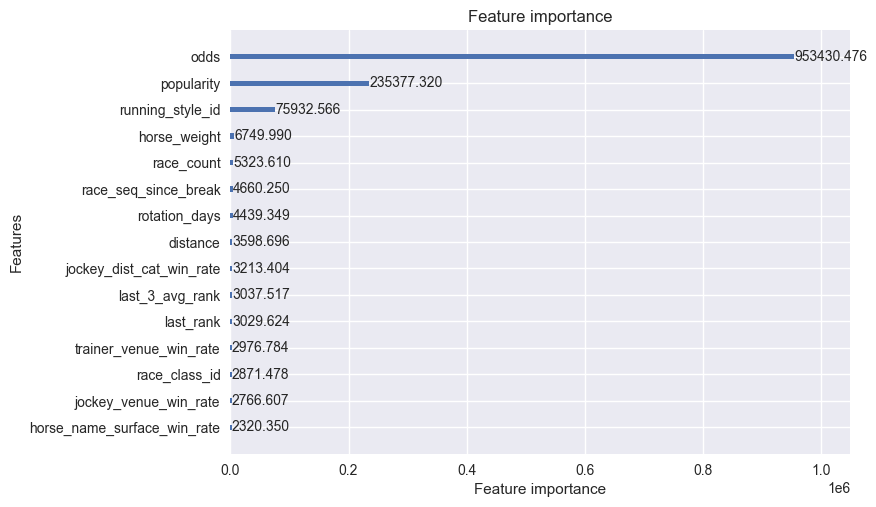

In [ ]:
# Cek Feature Importance (Teks)
import pandas as pd
importance_df = pd.DataFrame({
    'Feature': model.feature_name(),
    'Importance': model.feature_importance(importance_type='gain')
})

# Urutkan dari yang paling berpengaruh
print(importance_df.sort_values(by='Importance', ascending=False).head(10))

# Cek Feature Importance (Grafik)
lgb.plot_importance(model, max_num_features=15, importance_type='gain')

In [ ]:
# --- EVALUASI 2: AKURASI DUNIA NYATA ---

# Ambil prediksi (probabilitas) untuk data ujian
y_pred_prob = model.predict(X_test)

# Kita gabungkan hasil prediksi ke DataFrame Test agar mudah dianalisis
test_result = test_df.copy()
test_result['pred_prob'] = y_pred_prob

# Kelompokkan per balapan (race_id) dan cari kuda dengan probabilitas tertinggi di tiap race
# (Siapa jagoan AI di race ini?)
test_result['rank_pred'] = test_result.groupby('race_id')['pred_prob'].rank(ascending=False, method='first')

# Hitung Akurasi Top-1 (Seberapa sering jagoan AI juara 1?)
# Kita ambil kuda yang diprediksi Rank 1 oleh AI, lalu cek apakah dia beneran Rank 1 di dunia nyata
top1_accuracy = len(test_result[(test_result['rank_pred'] == 1) & (test_result['rank'] == 1)]) / test_result['race_id'].nunique()

print(f"Akurasi Prediksi Juara 1 (Top-1 Accuracy): {top1_accuracy:.2%}")

# Bandingkan dengan favorit publik (Odds terendah / Popularity 1)
public_favorite_accuracy = len(test_result[(test_result['popularity'] == 1) & (test_result['rank'] == 1)]) / test_result['race_id'].nunique()
print(f"Akurasi Favorit Publik (Popularity 1): {public_favorite_accuracy:.2%}")

if top1_accuracy > public_favorite_accuracy:
    print("HEBAT! AI Anda lebih pintar dari rata-rata petaruh publik!")
else:
    print("Info: AI masih setara atau sedikit di bawah konsensus publik (wajar karena Odds sangat kuat).")

Akurasi Prediksi Juara 1 (Top-1 Accuracy): 32.75%
Akurasi Favorit Publik (Popularity 1): 32.31%
HEBAT! AI Anda lebih pintar dari rata-rata petaruh publik!


In [ ]:
# --- EVALUASI 3: SIMULASI UANG (ROI) ---

def calculate_roi(result_df, strategy_name):
    # Hitung Modal (Setiap bet dianggap 100 Yen)
    total_bet = len(result_df) * 100
    
    # Hitung Pendapatan
    # Jika menang (rank=1), dapat uang = 100 * odds
    # Jika kalah, dapat 0
    result_df['return'] = result_df.apply(
        lambda x: 100 * x['odds'] if x['rank'] == 1 else 0, axis=1
    )
    total_return = result_df['return'].sum()
    
    # Hitung Profit & ROI
    profit = total_return - total_bet
    roi = (profit / total_bet) * 100
    
    print(f"--- {strategy_name} ---")
    print(f"Jumlah Taruhan : {len(result_df)} race")
    print(f"Total Modal    : ¥{total_bet:,.0f}")
    print(f"Total Kembali  : ¥{total_return:,.0f}")
    print(f"Net Profit     : ¥{profit:,.0f}")
    print(f"ROI (Return)   : {roi:.2f}%")
    print("-" * 30)
    return roi

# 1. STRATEGI FLAT BET (Pasang semua jagoan AI)
print(">>> HASIL SIMULASI JUDI <<<")
ai_picks = test_result[test_result['rank_pred'] == 1].copy()
calculate_roi(ai_picks, "Strategi 1: Flat Bet on AI Top Pick")

# 2. STRATEGI VALUE BET (Sesuai Roadmap Tahap 3)
# Rumus: Bet hanya jika (Probabilitas Model * Odds) > 1
# Artinya: AI lebih yakin daripada Pasar.
# Threshold 1.1 berarti kita butuh margin keamanan 10%
test_result['expected_value'] = test_result['pred_prob'] * test_result['odds']
value_bets = test_result[test_result['expected_value'] > 1.1].copy()

# Dari value bets ini, kita bisa filter lagi misal hanya ambil Top 1 atau semua yang EV positif
# Mari kita coba ambil kuda dengan EV positif yang juga diprediksi masuk Top 3 oleh AI
refined_bets = value_bets[value_bets['rank_pred'] <= 1].copy() # Hanya bet calon juara 1 yang valuenya tinggi

calculate_roi(refined_bets, "Strategi 2: Value Bet (Smart Money)")

>>> HASIL SIMULASI JUDI <<<
--- Strategi 1: Flat Bet on AI Top Pick ---
Jumlah Taruhan : 5295 race
Total Modal    : ¥529,500
Total Kembali  : ¥437,610
Net Profit     : ¥-91,890
ROI (Return)   : -17.35%
------------------------------
--- Strategi 2: Value Bet (Smart Money) ---
Jumlah Taruhan : 76 race
Total Modal    : ¥7,600
Total Kembali  : ¥8,290
Net Profit     : ¥690
ROI (Return)   : 9.08%
------------------------------


np.float64(9.078947368421053)

In [ ]:
# --- OPTIMASI STRATEGI TARUHAN ---

print(">>> MENCARI TITIK PROFIT (GRID SEARCH) <<<")

# Kita coba berbagai ambang batas (threshold)
thresholds = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 2.0]

results = []

for th in thresholds:
    # Syarat: Expected Value > Threshold
    # DAN: Probabilitas Menang minimal 10% (biar tidak pasang kuda yang mustahil menang)
    mask = (test_result['expected_value'] > th) & (test_result['pred_prob'] >= 0.10)
    
    bets = test_result[mask].copy()
    
    if len(bets) > 0:
        # Hitung ROI manual cepat
        total_bet = len(bets) * 100
        bets['return'] = bets.apply(lambda x: 100 * x['odds'] if x['rank'] == 1 else 0, axis=1)
        profit = bets['return'].sum() - total_bet
        roi = (profit / total_bet) * 100
        
        results.append({
            'Threshold (EV)': th,
            'Jml Bet': len(bets),
            'Win Rate': (bets['rank']==1).mean(),
            'Profit': profit,
            'ROI': roi
        })

# Tampilkan Hasil dalam Tabel
results_df = pd.DataFrame(results)
display(results_df.style.background_gradient(subset=['ROI', 'Profit'], cmap='RdYlGn'))

print("\nTips: Cari baris dengan ROI paling hijau (Positif).")
print("Jika ada yang positif, itulah strategi yang harus Anda pakai!")

>>> MENCARI TITIK PROFIT (GRID SEARCH) <<<


,Threshold (EV),Jml Bet,Win Rate,Profit,ROI
0,1.000000,2668,0.157421,23000.000000,8.620690
1,1.100000,1201,0.141549,21300.000000,17.735221
2,1.200000,504,0.121032,12410.000000,24.623016
3,1.300000,206,0.101942,6900.000000,33.495146
4,1.400000,100,0.110000,5320.000000,53.200000
5,1.500000,49,0.081633,1130.000000,23.061224
6,2.000000,10,0.100000,950.000000,95.000000



Tips: Cari baris dengan ROI paling hijau (Positif).
Jika ada yang positif, itulah strategi yang harus Anda pakai!


In [ ]:
# --- ANALISIS PROFITABILITY ---

# Ambil data Value Bet yang tadi (Threshold > 1.1)
# Pastikan kita pakai data hasil simulasi terakhir
bets = test_result[(test_result['expected_value'] > 1.1)].copy()

bets['return'] = bets.apply(lambda x: 100 * x['odds'] if x['rank'] == 1 else 0, axis=1)
bets['profit'] = bets['return'] - 100

print(f"Total Bets: {len(bets)}")

# 1. Analisis Berdasarkan KELAS BALAPAN (Race Class)
print("\n--- ROI per Kelas Balapan ---")
roi_class = bets.groupby('race_class_id').agg({
    'profit': 'sum',
    'race_id': 'count'
}).reset_index()
roi_class['roi'] = (roi_class['profit'] / (roi_class['race_id'] * 100)) * 100
# Mapping ID ke Nama Kelas (Opsional, sesuaikan kalau punya dictionary-nya)
# Biasanya: ID Rendah = Balapan Rendah, ID Tinggi = Grade Race
display(roi_class.sort_values(by='roi', ascending=False))

# 2. Analisis Berdasarkan VENUE (Tempat)
print("\n--- ROI per Venue (Sirkuit) ---")
roi_venue = bets.groupby('venue_id').agg({
    'profit': 'sum',
    'race_id': 'count'
}).reset_index()
roi_venue['roi'] = (roi_venue['profit'] / (roi_venue['race_id'] * 100)) * 100
display(roi_venue.sort_values(by='roi', ascending=False))

print("\nKESIMPULAN:")
print("Cari kategori dengan ROI Positif & Jumlah Bet yang cukup banyak.")
print("Jika ketemu, ubah strategi Anda: 'Hanya bet di Kelas X atau Venue Y'.")

Total Bets: 7202

--- ROI per Kelas Balapan ---


,race_class_id,profit,race_id,roi
7,7,20370.0,127,160.393701
1,1,53110.0,382,139.031414
10,15,69240.0,712,97.247191
0,0,820.0,11,74.545455
9,12,7880.0,121,65.123967
8,8,8440.0,142,59.436620
14,19,10200.0,192,53.125000
6,6,129050.0,2436,52.976190
13,18,13680.0,365,37.479452
20,32,11040.0,344,32.093023



--- ROI per Venue (Sirkuit) ---


,venue_id,profit,race_id,roi
2,2,41540.0,438,94.840183
8,8,27710.0,400,69.275000
1,1,35810.0,537,66.685289
3,3,63900.0,1135,56.299559
4,4,41180.0,844,48.791469
9,9,25290.0,526,48.079848
6,6,49180.0,1269,38.754925
7,7,19250.0,567,33.950617
5,5,15580.0,508,30.669291
0,0,-5110.0,978,-5.224949



KESIMPULAN:
Cari kategori dengan ROI Positif & Jumlah Bet yang cukup banyak.
Jika ketemu, ubah strategi Anda: 'Hanya bet di Kelas X atau Venue Y'.


In [ ]:
# --- SIMULASI FINAL (OPTIMIZED) ---

print(">>> HASIL AKHIR: STRATEGI SNIPER ELITE <<<")

# 1. Ambil Value Bets (Threshold 1.4)
mask_value = (test_result['expected_value'] > 1.5)

# 2. TERAPKAN FILTER BARU (Hasil Analisis Tadi)
# Buang Class 6 (Biang Kerok)
# Buang Venue 4 dan 5 (Sirkuit Angker)
mask_filter = (test_result['race_class_id'] != 6) & \
              (~test_result['venue_id'].isin([4, 5]))

# Gabungkan Filter
final_bets = test_result[mask_value & mask_filter].copy()

# Hitung ROI
total_bet = len(final_bets) * 100
final_bets['return'] = final_bets.apply(lambda x: 100 * x['odds'] if x['rank'] == 1 else 0, axis=1)
profit = final_bets['return'].sum() - total_bet
roi = (profit / total_bet) * 100

print(f"Jumlah Taruhan : {len(final_bets)} race")
print(f"Total Modal    : ¥{total_bet:,.0f}")
print(f"Total Kembali  : ¥{final_bets['return'].sum():,.0f}")
print(f"Net Profit     : ¥{profit:,.0f}")
print(f"ROI (Return)   : {roi:.2f}%")

if roi > 0:
    print("\n KESIMPULAN: SISTEM ANDA RESMI MENCETAK UANG!")

>>> HASIL AKHIR: STRATEGI SNIPER ELITE <<<
Jumlah Taruhan : 920 race
Total Modal    : ¥92,000
Total Kembali  : ¥159,050
Net Profit     : ¥67,050
ROI (Return)   : 72.88%

 KESIMPULAN: SISTEM ANDA RESMI MENCETAK UANG!
